## Read Data

In [1]:
from importlib import reload
import numpy as np

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

data_dir = '/home/taot/data/AI/pytorch-tutorial/data/'

print(findFiles(data_dir + 'names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(data_dir + 'names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/home/taot/data/AI/pytorch-tutorial/data/names/Irish.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/German.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/Japanese.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/Korean.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/Vietnamese.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/Dutch.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/Italian.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/Greek.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/Scottish.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/Polish.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/Spanish.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/Chinese.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/Portuguese.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/French.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/Russian.txt', '/home/taot/data/AI/pytorch-tutorial/data/names/Arabic.txt', '/home/tao

## Turn into Tensor

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

torch.Size([5, 1, 57])


## Creating the Network

In [4]:
import torch.nn as nn
from torch.autograd import Variable

In [5]:
import rnn; reload(rnn)

<module 'rnn' from '/home/taot/github/playground/pytorch-tutorial/classify-names/rnn.py'>

In [9]:
n_letters

57

In [8]:
n_categories

18

In [7]:
n_hidden = 128

In [10]:
net = rnn.RNN(n_letters, n_hidden, n_categories)

In [11]:
hidden = net.initHidden()

In [11]:
input = Variable(letterToTensor('A'))
output, hidden = net.forward(input, hidden)

In [12]:
input = Variable(lineToTensor('Albert'))
hidden = net.initHidden()

output, next_hidden = net(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.9960 -2.8312 -2.9709 -2.9272 -2.9264 -2.7715 -2.9043 -2.8312 -2.9082 -2.7587

Columns 10 to 17 
-2.8669 -2.8462 -3.0230 -2.9170 -2.9371 -2.8739 -2.9314 -2.8487
[torch.FloatTensor of size 1x18]



## Training

### Prepare for training

In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

# print(categoryFromOutput(output))

In [14]:
output.data.topk(1)

(
 -2.7587
 [torch.FloatTensor of size 1x1], 
  9
 [torch.LongTensor of size 1x1])

In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Demarchis
category = Polish / line = Krol
category = Korean / line = So
category = Vietnamese / line = Doan
category = Czech / line = Novy Novy
category = Scottish / line = Hamilton
category = Chinese / line = Shuai
category = Vietnamese / line = Chau
category = Spanish / line = Gutierrez
category = English / line = Fyall


### Training the Network

In [15]:
criterion = nn.NLLLoss()

In [16]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = net.initHidden()

    net.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = net(line_tensor[i], hidden)
        
#     print("category_tensor.shape: " + str(category_tensor.shape))

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in net.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

In [17]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.3933 Santana / Japanese ✗ (Spanish)
10000 10% (0m 12s) 2.6934 Ferreira / Japanese ✗ (Portuguese)
15000 15% (0m 19s) 3.4803 Martin / Scottish ✗ (German)
20000 20% (0m 25s) 1.6230 Kieu / Vietnamese ✓
25000 25% (0m 30s) 2.5499 Terrazas / Portuguese ✗ (Spanish)
30000 30% (0m 36s) 1.2252 Nataga / Japanese ✓
35000 35% (0m 42s) 1.7107 Schoonenburg / Dutch ✓
40000 40% (0m 49s) 1.1842 Gauk / Chinese ✓
45000 45% (0m 55s) 2.8165 Petit / French ✗ (Spanish)
50000 50% (1m 1s) 0.7919 Sedmikova / Czech ✓
55000 55% (1m 8s) 1.8632 Taidhg / Arabic ✗ (Irish)
60000 60% (1m 14s) 0.7168 Mateus / Portuguese ✓
65000 65% (1m 20s) 1.1649 Ho / Korean ✗ (Vietnamese)
70000 70% (1m 26s) 1.1222 Gutermuth / German ✓
75000 75% (1m 33s) 0.2626 Ly / Vietnamese ✓
80000 80% (1m 39s) 2.0518 Tsai  / Arabic ✗ (Korean)
85000 85% (1m 45s) 1.6016 Campos / Greek ✗ (Portuguese)
90000 90% (1m 51s) 1.9916 Armsden / Dutch ✗ (English)
95000 95% (1m 56s) 0.5968 Robert / Dutch ✓
100000 100% (2m 2s) 3.8523 Chung / Korea

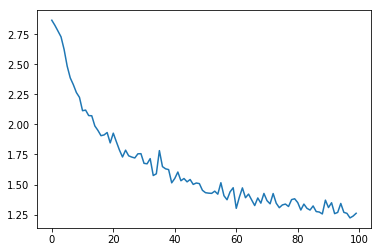

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Evaluating the Results

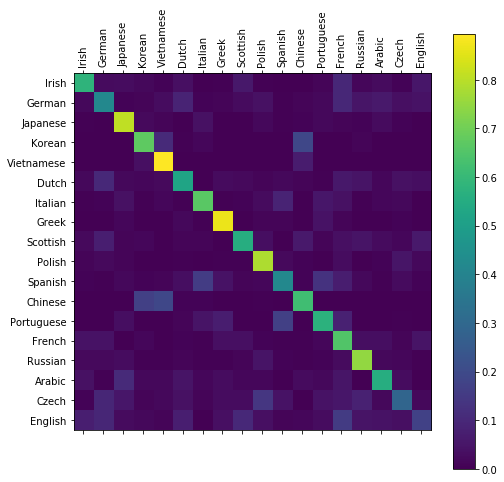

In [19]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = net.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = net(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [21]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

In [46]:
predict('Hinton')
predict('Wang')
predict('Satoshi')


> Hinton
(-0.61) Scottish
(-1.65) English
(-2.89) Polish

> Wang
(-1.00) Chinese
(-1.11) Korean
(-2.04) Scottish

> Satoshi
(-1.19) Japanese
(-1.59) Italian
(-2.47) Polish


## Misc Tests

In [30]:
a = np.asarray([[1,2,3], [1,2,3]])
a

array([[1, 2, 3],
       [1, 2, 3]])

In [41]:
t = torch.from_numpy(a)
t = t.type(torch.FloatTensor)

In [43]:
m = nn.LogSoftmax()  
# input = Variable(torch.randn(2, 3))

input = Variable(t)
print(input)
print(m(input)) 

Variable containing:
 1  2  3
 1  2  3
[torch.FloatTensor of size 2x3]

Variable containing:
-2.4076 -1.4076 -0.4076
-2.4076 -1.4076 -0.4076
[torch.FloatTensor of size 2x3]



/home/taot/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [8]:
sum([1,2,3])

6

In [15]:
sum([len(category_lines[k]) for k in category_lines])

20074